In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import yfinance as yfinance
import pandas as pd
from datetime import datetime, timedelta

class Portfolio:
    
    def __init__(self, portfolio: dict):
        self.portfolio = portfolio
        self.symbols = list(portfolio.keys())
        self.prices: pd.DataFrame = self.get_prices(portfolio)
        self.dist = pd.DataFrame(self.present_distribution(), index=[datetime.now().date()])
        self.cash_value = sum(map(lambda x: x[1] * self.portfolio[x[0]], self.prices.iloc[-1].items()))
        
    def present_distribution(self):
        total = sum(self.portfolio.values())
        distribution = {ticker: shares/total for ticker, shares in self.portfolio.items()}
        return distribution

    def get_prices(self, portfolio: dict):
        tickers = list(portfolio.keys())
        data = yfinance.download(tickers, period='5y')
        prices = data['Adj Close'].round(2)
        return prices
    
    def get_attractiveness(self, n_years=3):
        attractiveness_df = pd.DataFrame()
        for ticker in self.symbols:
            historical_prices: pd.DataFrame = self.prices[ticker].loc[datetime.today()-timedelta(days=n_years*365):]
            mean = historical_prices.mean()
            std = historical_prices.std()
            last_price = historical_prices.iloc[-1]
            attractiveness = (last_price - mean)/std
            attractiveness_df[ticker] = [attractiveness, last_price, mean, std]
        attractiveness_df = attractiveness_df.T
        attractiveness_df.columns = ['Attractiveness', 'Last Price', 'Mean', 'Std']
        return attractiveness_df.round(2)
    
    def plot_attractiveness(self):
        self.get_attractiveness().pipe(
            lambda df: sns.barplot(x=df.index, y=df['Attractiveness'], hue=df['Attractiveness'] > 0)
        ).set(
            title='Attractiveness of Stocks'
        )
        plt.show()
            
    

In [10]:
portfolio = Portfolio(portfolio = {'TSLA':2, 'MSFT':3, 'SPOT':5, 'SNAP':10})

[*********************100%%**********************]  4 of 4 completed


### Attractiveness weights
1. Thresholds of weighing that must be eventually learned by the model
2. weight based transaction on stocks apply to all stocks
3. 

In [11]:
portfolio.get_attractiveness(n_years=1)

,Attractiveness,Last Price,Mean,Std
TSLA,-1.26,181.06,223.99,33.95
MSFT,1.96,405.65,327.13,40.01
SPOT,2.62,223.25,156.89,25.30
SNAP,2.09,16.75,11.43,2.54


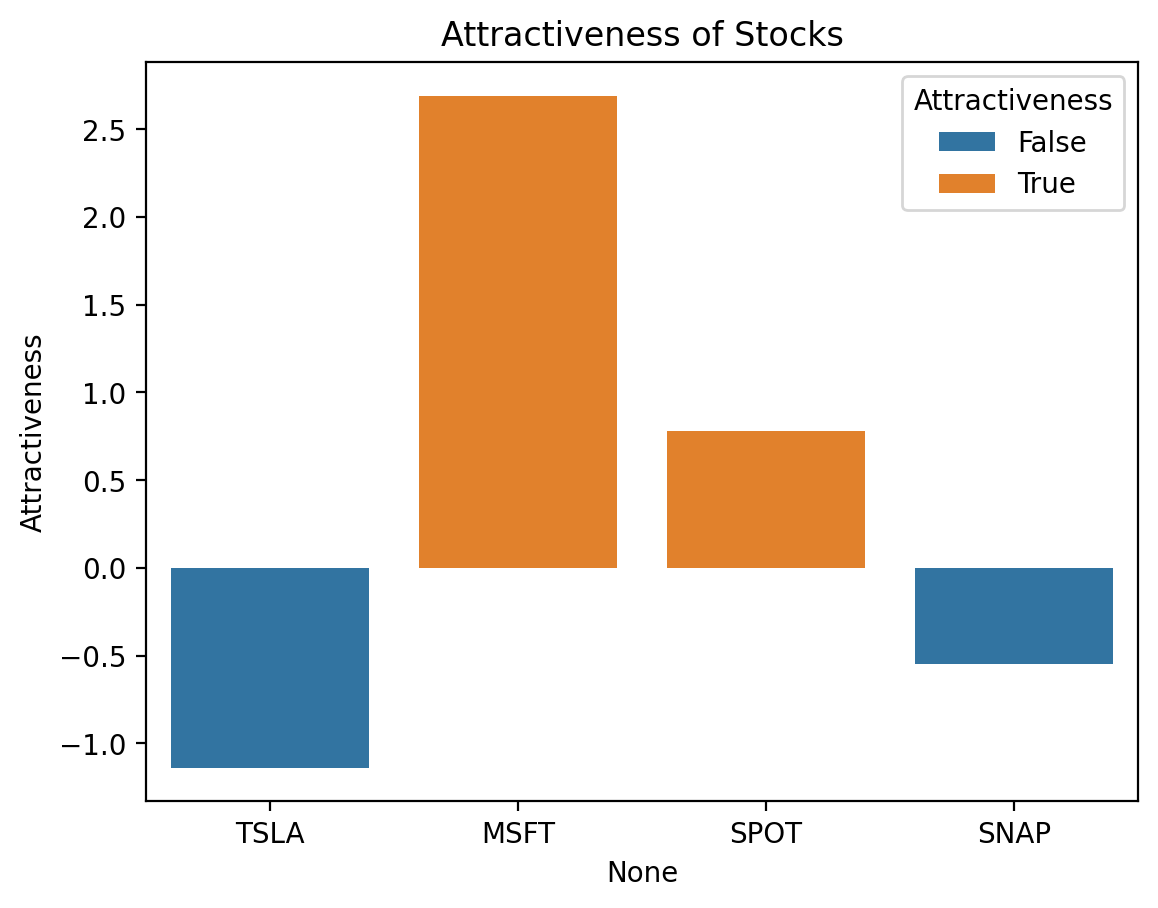

In [12]:
portfolio.plot_attractiveness()

In [14]:
import altair as alt
import numpy as np
df = portfolio.get_attractiveness(n_years=1)
df['Stock'] = df.index  # Add this line to specify the field name correctly
df['Color'] = df['Attractiveness'].apply(lambda x: 'green' if x > 0 else 'red')
# Define color scale for gradientation
color_scale = alt.Scale(
    domain=[df['Attractiveness'].min(), df['Attractiveness'].max()],
    range=['#FF0000', '#00FF00'],
    type='linear',
    interpolate='rgb',
    zero=False
)

# Create Vega-Lite chart
chart = alt.Chart(df).mark_bar().encode(
    x='Stock',
    y='Attractiveness',
    color=alt.Color('Attractiveness', scale=color_scale, sort=alt.SortField(field='Attractiveness', order='ascending')),
    tooltip=['Stock', 'Attractiveness']
).properties(
    title='Your Portfolio Attractiveness Plot'
)
chart

alt.Chart(...)

# Current Portfolio


In [1]:
import pandas as pd

pf = pd.read_csv('nasdaq weights adjustment.csv', index_col='ticker')
pf.drop('Unnamed: 0', axis=1, inplace=True)
pf.loc[:,['nd_weights', 'portfolio_weight']] =pf.loc[:,['nd_weights', 'portfolio_weight']].apply(lambda x: x.str.replace('%', '').astype(float))
pf = pf.loc[:,['company_name','nd_weights', 'portfolio_weight']].dropna()
pf

,company_name,nd_weights,portfolio_weight
ticker,,,
MSFT,Microsoft Corp,8.79,16.55679
AAPL,Apple Inc,8.18,15.407798
NVDA,NVIDIA Corp,5.56,10.47
AMZN,Amazon.com Inc,5.19,9.78
META,Meta Platforms Inc,4.96,9.34
AVGO,Broadcom Inc,4.51,8.5
TSLA,Tesla Inc,2.82,5.31
COST,Costco Wholesale Corp,2.48,4.67
GOOGL,Alphabet Inc,2.34,4.41


In [2]:
pf.loc[:, 'portfolio_weight'].sum()

99.99458843473352

In [3]:
from Portfolio import Portfolio
portfolio = Portfolio(portfolio = pf['portfolio_weight'].to_dict())

[*********************100%%**********************]  13 of 13 completed


In [4]:
portfolio.portfolio

{'MSFT': 16.5567903559993,
 'AAPL': 15.4077980787342,
 'NVDA': 10.47,
 'AMZN': 9.78,
 'META': 9.34,
 'AVGO': 8.5,
 'TSLA': 5.31,
 'COST': 4.67,
 'GOOGL': 4.41,
 'GOOG': 4.29,
 'AMD': 4.03,
 'NFLX': 3.69,
 'ADBE': 3.54}

In [5]:
portfolio.get_performance(n_years=[1,3,5])

,% of portfolio,1y,contributed_growth,3y,5y
MSFT,16.56,61.29,4515.25,76.86,272.71
AAPL,15.41,14.07,4474.71,43.52,290.42
NVDA,10.47,281.24,20840.23,582.16,1990.47
AMZN,9.78,89.71,1050.53,13.52,107.42
META,9.34,179.98,1794.55,88.70,192.14
AVGO,8.50,117.12,3991.20,215.31,469.55
TSLA,5.31,0.49,4303.14,-24.17,810.38
COST,4.67,58.36,1096.98,128.92,234.90
GOOGL,4.41,48.62,555.09,32.11,125.87
GOOG,4.29,48.69,550.86,32.19,128.41
